In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sp
import math
import warnings
import matplotlib.pyplot as plt
import random


from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

In [2]:
def read_file(filename):
    adata = sc.read_h5ad(filename)

    return adata

In [3]:
def preprocess_file(adata):
    #get rid of cells with fewer than 200 genes
    sc.pp.filter_cells(adata, min_genes=200)
    #get rid of genes that are found in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    #get rid of cells whose annotation is unknown
    adata = adata[~adata.obs.annotation.isin(['Unknown'])]
    #data normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    return adata

In [4]:
def select_best_features(adata, k_best_value):
    feature_selector = SelectKBest(k = k_best_value)
    y = adata.obs.annotation
    adata.feature_selected = np.zeros((len(adata.obs.annotation),2))
    adata.feature_selected[:,0]= adata.obsm['spatial'][:,0]
    adata.feature_selected[:,1]= adata.obsm['spatial'][:,1]
    
    feature_selected = feature_selector.fit_transform(adata.X,y)
    adata.feature_selected = np.hstack((adata.feature_selected, feature_selected.toarray() ))
    scaler = StandardScaler()
    adata.feature_selected = scaler.fit_transform(adata.feature_selected,y)

    return adata 

In [5]:
def get_all_predictions(X, y, clf, k):
    strtfdKFold = StratifiedKFold(n_splits=k)
    kfold = strtfdKFold.split(X, y)
    predictions = None

    for fold_index, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        if predictions is None:
            predictions = clf.predict(X)
        else:
            predictions = np.vstack((predictions, clf.predict(X)))
    return predictions

In [6]:
def refine_annotations(predictions, y, l):
    new_annotations = y.copy()
    count_refined = 0
    for col_index in range(predictions.shape[1]):
        column = predictions[:,col_index].T
        count_different = len(column[column != y[col_index]])
        if count_different <= l:
            continue
        count_different_by_class = dict()
        for label in column[column != y[col_index]]:
            if label in count_different_by_class:
                count_different_by_class[label] += 1
            else:
                count_different_by_class[label] = 1
        label_with_max = max(count_different_by_class, key=lambda key: count_different_by_class[key])
        max_value = count_different_by_class[label_with_max]
        if max_value > l:
            #print(col_index, y[col_index], label_with_max)
            new_annotations[col_index] = label_with_max
            count_refined += 1
    return new_annotations, count_refined

In [7]:
def plot_values(results_table):
    fig = plt.figure(figsize=(100,100), layout='constrained')

    #features
    xdata = results_table[:, 0]
    #folds
    ydata = results_table[:, 1]
    #l
    zdata = results_table[:, 2]

    ann_data_changed = results_table[:, 3].flatten()

    ax3d = plt.figure().add_subplot(111,projection = '3d')

    ax3d.scatter(xdata, ydata, zdata)

    for x, y, z, label in zip(xdata,ydata, zdata, ann_data_changed):
        ax3d.text(x,y,z,str(label), fontsize=6)

    ax3d.set_xlabel('Features')
    ax3d.set_ylabel('Folds')
    ax3d.set_zlabel('L')
    ax3d.grid(False)

    plt.title("Number of changed annotations per number of features, k and l")
    return plt

In [8]:
def fun_image_representation(filename, results_table,new_annotations_table):
    for i in range(0,3):
        row = random.randint(0,len(results_table))
        table_row = results_table[row]
        new_ann_row= new_annotations_table[row]
        adata.obs['new_annotation'] = new_ann_row;
        adata.uns['new_annotation_colors'] = adata.uns['annotation_colors']
        text ="For {} with features={}, folds = {} and l={},\n the number of features changed is {}".format(filename, table_row[0], table_row[1],table_row[2],table_row[3])
        sp.pl.spatial_scatter(adata,shape = None, color=["new_annotation","annotation"], title =text)

In [9]:
def train_models(adata):
    results_table = None
    new_annotations_table = None
    for number_of_features in k_best_features:
        select_best_features(adata, number_of_features)
        print("**started {} feature **".format(number_of_features))
        for number_of_folds in k_number_of_folds:

            predictions = get_all_predictions(adata.feature_selected, adata.obs.annotation, sgd, number_of_folds)
            for l in range(math.ceil(l_value_percentage * number_of_folds), number_of_folds):
                new_annotations, count_refined = refine_annotations(predictions, adata.obs.annotation, l)
                result = np.array([number_of_features, number_of_folds, l, count_refined])
                if results_table is None:
                    results_table = result
                else:
                    results_table = np.vstack((results_table, result))
                if new_annotations_table is None:
                    new_annotations_table = new_annotations
                else:
                    new_annotations_table = np.vstack((new_annotations_table, new_annotations))
    print("**done**")
    return results_table, new_annotations_table

In [10]:
filename_mouse_embryo = '../E9.5_E1S1.MOSTA.h5ad'
filename_mouse_brain = '../Mouse_brain_cell_bin.h5ad'

k_best_features = [10, 20, 50, 100]
k_number_of_folds = [3, 5, 7, 10]
l_value_percentage = 0.5
sgd = SGDClassifier()

In [16]:
adata = read_file(filename_mouse_embryo)
adata = preprocess_file(adata)

In [17]:
embryo_results, embryo_annotations= train_models(adata)

**started 10 feature **
**started 20 feature **
**started 50 feature **
**started 100 feature **
**done**


<Figure size 10000x10000 with 0 Axes>

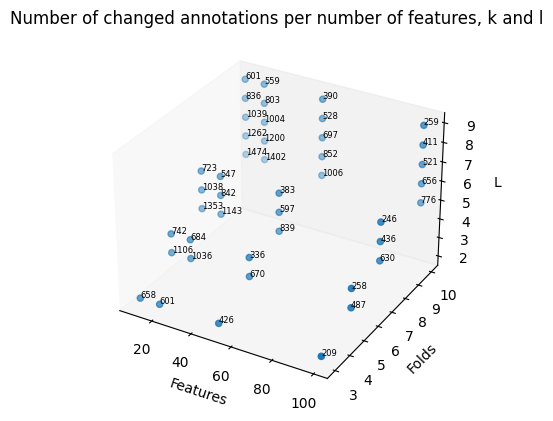

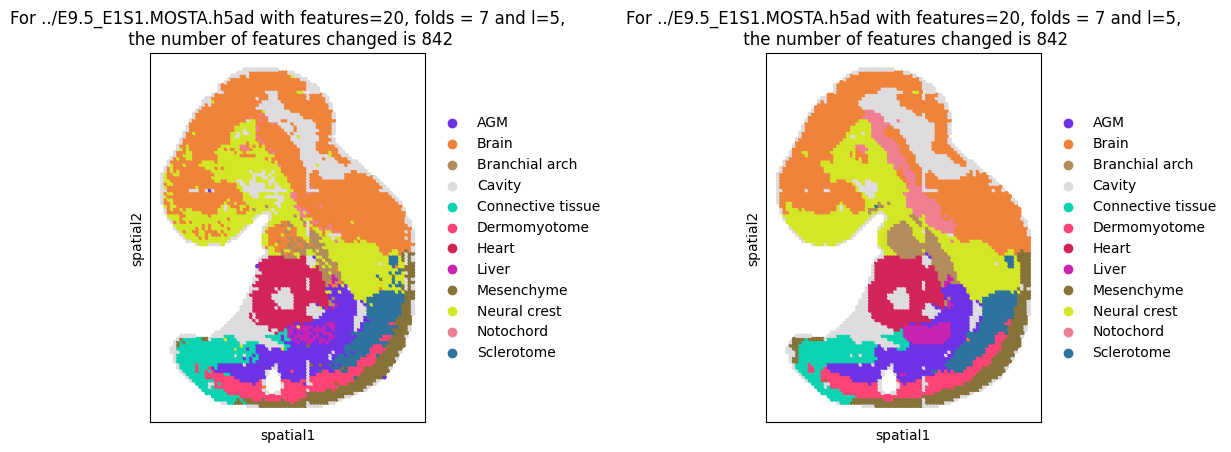

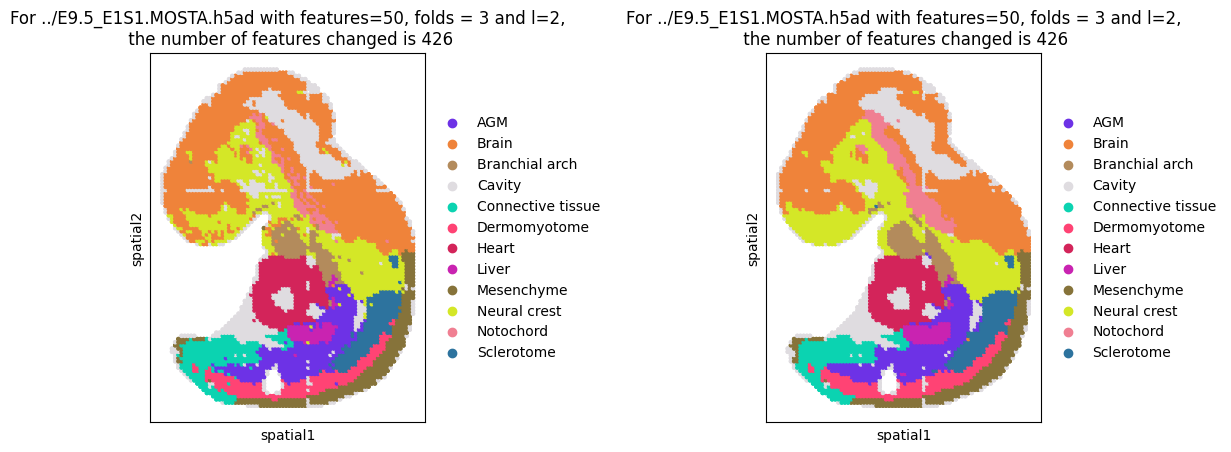

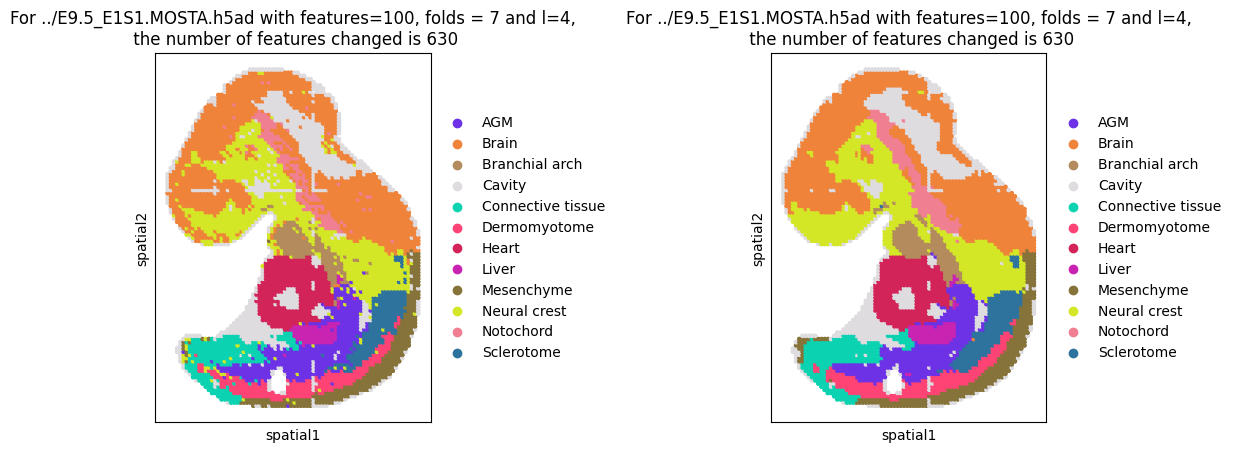

In [18]:
plt = plot_values(embryo_results)
fun_image_representation(filename_mouse_embryo, embryo_results,embryo_annotations)

In [11]:
adata = read_file(filename_mouse_brain)
adata = preprocess_file(adata)

In [12]:
brain_results, brain_annotations= train_models(adata)

**started 10 feature **
**started 20 feature **
**started 50 feature **
**started 100 feature **
**done**


<Figure size 10000x10000 with 0 Axes>

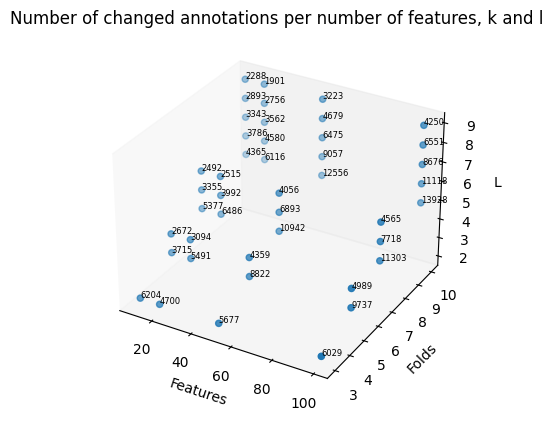

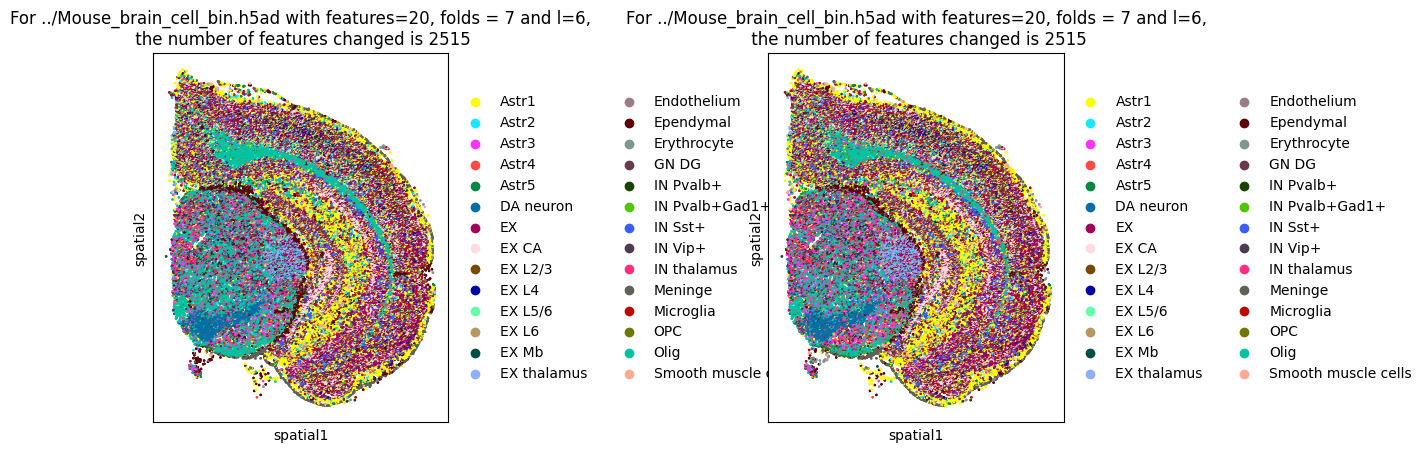

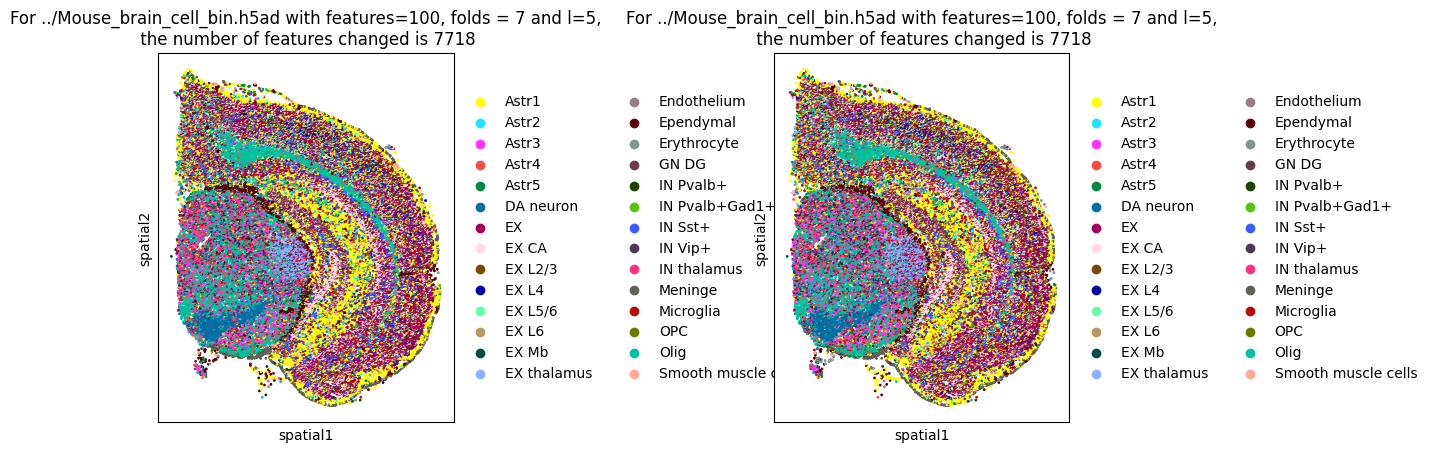

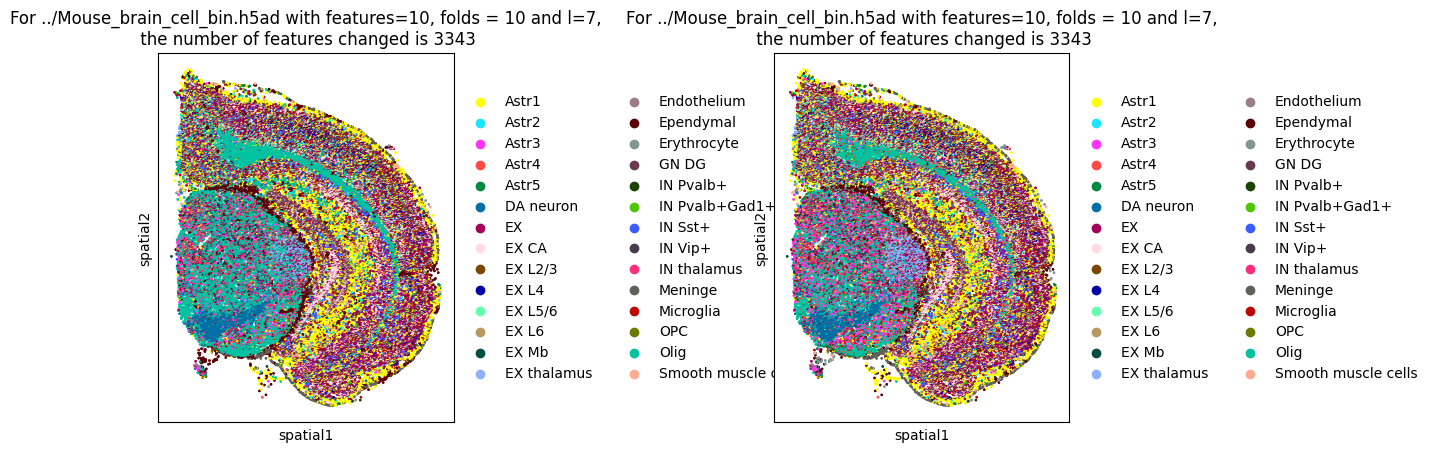

In [15]:
plt = plot_values(brain_results)
fun_image_representation(filename_mouse_brain, brain_results,brain_annotations)